# CTG Data pre-processing and EDA 

## Import libraries 

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from datetime import datetime

import re

import warnings
warnings.filterwarnings('ignore')

## Upload the csv file downloaded from ClinicalTrial.gov website

In [5]:
df = pd.read_csv('ctg_studies_all.csv')
#data exploration
print('columns are:', df.columns)
print('Shape is:', df.shape)
missing = df.isnull().sum()
print('missing values are:',missing)


columns are: Index(['NCT Number', 'Study Title', 'Study URL', 'Acronym', 'Study Status',
       'Brief Summary', 'Study Results', 'Conditions', 'Interventions',
       'Primary Outcome Measures', 'Secondary Outcome Measures',
       'Other Outcome Measures', 'Sponsor', 'Collaborators', 'Sex', 'Age',
       'Phases', 'Enrollment', 'Funder Type', 'Study Type', 'Study Design',
       'Other IDs', 'Start Date', 'Primary Completion Date', 'Completion Date',
       'First Posted', 'Results First Posted', 'Last Update Posted',
       'Locations'],
      dtype='object')
Shape is: (536389, 29)
missing values are: NCT Number                         0
Study Title                        0
Study URL                          0
Acronym                       385908
Study Status                       0
Brief Summary                    914
Study Results                      0
Conditions                       948
Interventions                  53394
Primary Outcome Measures       17544
Secondary Outcome 

### Handling with missing data

In [6]:
#Drop unnecessary columns with high number of missing data 
columns_to_drop = ['Acronym', 'Secondary Outcome Measures', 'Other Outcome Measures','Results First Posted','Collaborators','Results First Posted']
df = df.drop(columns=columns_to_drop)

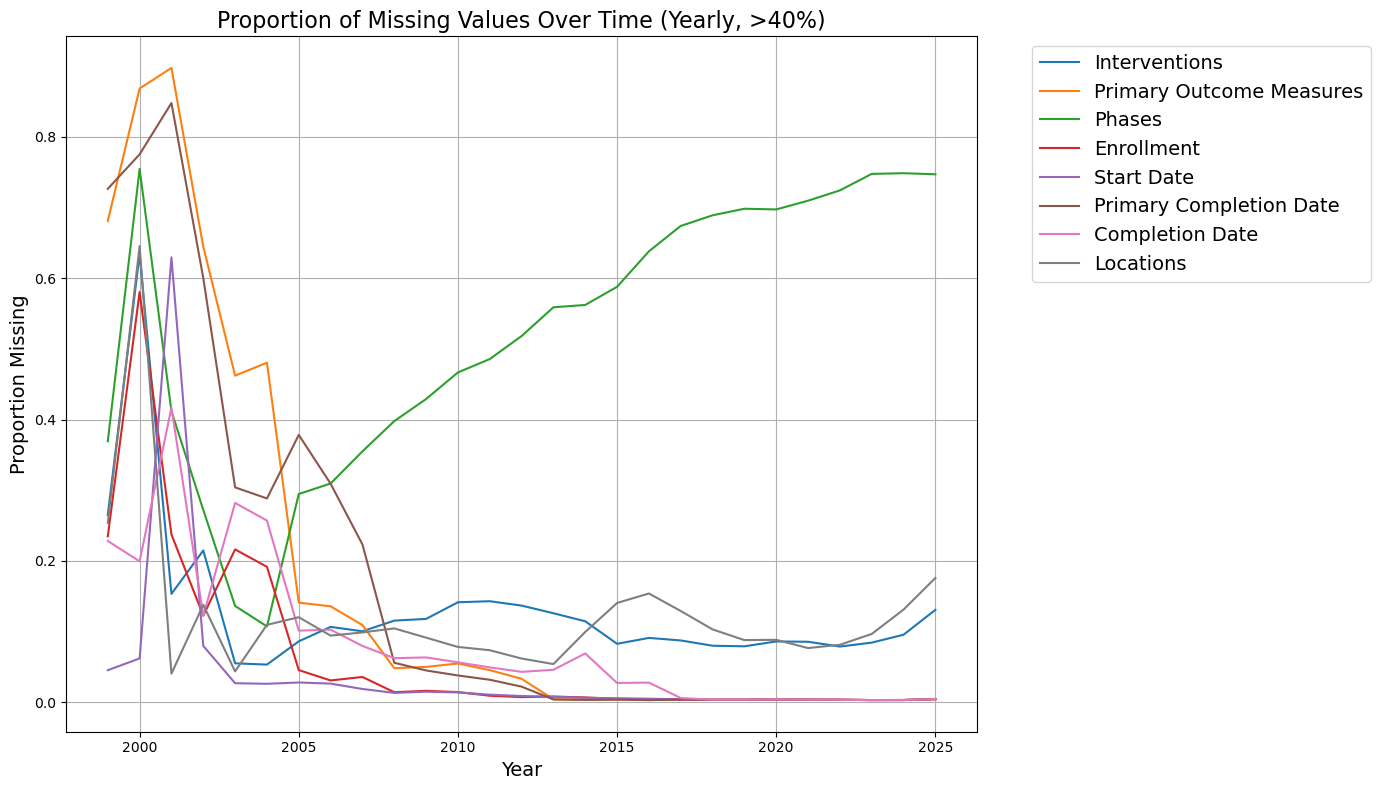

In [9]:
# Checking the distribution of missing values over time

# Ensure 'First Posted' is in datetime format
df['First Posted'] = pd.to_datetime(df['First Posted'], errors='coerce')

# Set index and group by year
df_by_year = df.set_index('First Posted').sort_index()
missing_ratio_by_year = df_by_year.resample('Y').apply(lambda x: x.isna().mean())

# Filter columns with >40% missing values in at least one year
cols_to_plot = missing_ratio_by_year.columns[missing_ratio_by_year.max() > 0.4]

# Plot
plt.figure(figsize=(14, 8))
for col in cols_to_plot:
    plt.plot(missing_ratio_by_year.index.year, missing_ratio_by_year[col], label=col)

plt.title('Proportion of Missing Values Over Time (Yearly, >40%)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Proportion Missing', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
plt.tight_layout()
plt.grid(True)
plt.show()


In [14]:
# Set a threshold: rows with more than 40% missing values
threshold = df.shape[1] /2.5

# View rows with more than 40% missing values
mostly_null_rows = df[df.isnull().sum(axis=1) > threshold]
print(mostly_null_rows.shape)
mostly_null_rows.head(1)


(939, 24)


,NCT Number,Study Title,Study URL,Study Status,Brief Summary,Study Results,Conditions,Interventions,Primary Outcome Measures,Sponsor,...,Funder Type,Study Type,Study Design,Other IDs,Start Date,Primary Completion Date,Completion Date,First Posted,Last Update Posted,Locations
225,NCT04116879,[Trial of device that is not approved or clear...,https://clinicaltrials.gov/study/NCT04116879,WITHHELD,NaN,NO,NaN,NaN,NaN,[Redacted],...,NaN,NaN,NaN,VC2018-5,NaN,NaN,NaN,2019-10-07,2021-12-08,NaN


In [15]:
# Drop rows with more than 40% missing values
df = df[df.isnull().sum(axis=1) <= threshold]
df.isnull().sum()

NCT Number                       0
Study Title                      0
Study URL                        0
Study Status                     0
Brief Summary                    0
Study Results                    0
Conditions                       9
Interventions                52480
Primary Outcome Measures     16605
Sponsor                          0
Sex                            394
Age                              0
Phases                      328343
Enrollment                    6052
Funder Type                      0
Study Type                       0
Study Design                   967
Other IDs                       56
Start Date                    4284
Primary Completion Date      20871
Completion Date              15729
First Posted                     0
Last Update Posted               0
Locations                    54259
dtype: int64

In [16]:
# Fill missing values in "Sex" with the common ('All')
df['Sex'].fillna(df['Sex'].mode()[0], inplace=True)

# Drop studies that did not enrolled any subjects, or enrolled less then 3 patients 
df = df[~(df['Enrollment'].isna() | (df['Enrollment'] < 3))]

# Drop studies without a start date
#df = df[~(df['Start Date'].isna())]

# Fill missing values in "Phases" with the 'NO_PHASE'
df['Phases'].fillna('NO_PHASE', inplace=True)

# List of columns to replace NaN with 'Unknown'
columns_to_fill = [
    'Conditions',
    'Primary Outcome Measures',
    'Study Design',
    'Locations',
    'Other IDs'
  ]
#Replace NaN values with 'Unknown' in the specified columns
df[columns_to_fill] = df[columns_to_fill].fillna('Unknown')

df.isnull().sum()      
                      

NCT Number                      0
Study Title                     0
Study URL                       0
Study Status                    0
Brief Summary                   0
Study Results                   0
Conditions                      0
Interventions               49939
Primary Outcome Measures        0
Sponsor                         0
Sex                             0
Age                             0
Phases                          0
Enrollment                      0
Funder Type                     0
Study Type                      0
Study Design                    0
Other IDs                       0
Start Date                   1626
Primary Completion Date     15688
Completion Date             11472
First Posted                    0
Last Update Posted              0
Locations                       0
dtype: int64

In [17]:
#Replace NaN values in the Intervention column with 'Observation' in the specified columns
df.loc[(df['Study Type'] == 'OBSERVATIONAL') & (df['Interventions'].isna()), 'Interventions'] = 'Observation'
df.Interventions.isnull().sum()

0

In [18]:
# a function that check the formats of the dates:
def classify_date_format(s):
    if pd.isna(s):
        return 'missing'
    s = str(s)
    if re.fullmatch(r'\d{4}-\d{2}-\d{2}', s):
        return 'yyyy-mm-dd'
    elif re.fullmatch(r'\d{2}-\d{4}', s):
        return 'mm-yyyy'
    elif re.fullmatch(r'\d{4}-\d{2}', s):
        return 'yyyy-mm'
    else:
        return 'other'


In [19]:
# Assigning formatted date columns
df['Start_date_formated'] = df['Start Date'].apply(classify_date_format)
df['Prim_completion_date_formated'] = df['Primary Completion Date'].apply(classify_date_format)
df['Completion_date_formated'] = df['Completion Date'].apply(classify_date_format)

# Print value counts for each
print(df['Start_date_formated'].value_counts())
print(df['Prim_completion_date_formated'].value_counts())
print(df['Completion_date_formated'].value_counts())


Start_date_formated
yyyy-mm-dd    306874
yyyy-mm       201222
missing         1626
Name: count, dtype: int64
Prim_completion_date_formated
yyyy-mm-dd    283050
yyyy-mm       210984
missing        15688
Name: count, dtype: int64
Completion_date_formated
yyyy-mm-dd    282746
yyyy-mm       215504
missing        11472
Name: count, dtype: int64


In [20]:
#formatting the dates to yyyy-mm format:

def to_yyyy_mm(s):
    if pd.isna(s):
        return None
    s = str(s)
    try:
        if re.fullmatch(r'\d{4}-\d{2}-\d{2}', s):
            return datetime.strptime(s, '%Y-%m-%d').strftime('%Y-%m')
        elif re.fullmatch(r'\d{2}-\d{4}', s):
            return datetime.strptime(s, '%m-%Y').strftime('%Y-%m')
        elif re.fullmatch(r'\d{4}-\d{2}', s):
            return s
    except:
        return None

df['Start_date_formated'] = df['Start Date'].apply(to_yyyy_mm)
df['Primary_Completion_date_formated'] = df['Primary Completion Date'].apply(to_yyyy_mm)
df['Completion_date_formated'] = df['Completion Date'].apply(to_yyyy_mm)

df[
    ['NCT Number','Start Date', 'Start_date_formated',
     'Primary Completion Date', 'Primary_Completion_date_formated',
     'Completion Date', 'Completion_date_formated']
].head(5)



,NCT Number,Start Date,Start_date_formated,Primary Completion Date,Primary_Completion_date_formated,Completion Date,Completion_date_formated
1,NCT00517179,2006-04,2006-04,NaN,None,2007-05,2007-05
2,NCT00812279,2008-11,2008-11,2009-02,2009-02,2009-02,2009-02
3,NCT03878979,2019-07-08,2019-07,2023-10-17,2023-10,2023-10-17,2023-10
4,NCT03058679,2017-09-29,2017-09,2020-03-01,2020-03,2020-03-01,2020-03
5,NCT03960879,2019-06-01,2019-06,2020-06-01,2020-06,2020-06-01,2020-06


In [21]:
#dealing with missing dates: defining study statuses where a missing date are expected
ongoing_statuses = [
    'RECRUITING',
    'NOT_YET_RECRUITING',
    'ACTIVE_NOT_RECRUITING',
    'ENROLLING_BY_INVITATION',
    'SUSPENDED'
]

# Create a mask for studies that are completed but have missing dates
missing_primary_comp_date = (
    df['Study Status'].isin(['COMPLETED', 'TERMINATED', 'WITHDRAWN']) &
    df['Primary_Completion_date_formated'].isna()
)

missing_completion_date = (
    df['Study Status'].isin(['COMPLETED', 'TERMINATED', 'WITHDRAWN']) &
    df['Completion_date_formated'].isna()
)

print("Missing Primary Completion Date (unexpected):", missing_primary_comp_date.sum())
print("Missing Completion Date (unexpected):", missing_completion_date.sum())


Missing Primary Completion Date (unexpected): 12464
Missing Completion Date (unexpected): 7064


In [22]:
# Drop studies with unexpected missing Completion Dates
df = df[~missing_completion_date]
# Drop Primary Completion Date column
columns_to_drop = ['Primary_Completion_date_formated','Primary Completion Date','Completion Date','Start Date']
#df = df.drop(columns=columns_to_drop)
df.isnull().sum()


NCT Number                              0
Study Title                             0
Study URL                               0
Study Status                            0
Brief Summary                           0
Study Results                           0
Conditions                              0
Interventions                           0
Primary Outcome Measures                0
Sponsor                                 0
Sex                                     0
Age                                     0
Phases                                  0
Enrollment                              0
Funder Type                             0
Study Type                              0
Study Design                            0
Other IDs                               0
Start Date                            989
Primary Completion Date             13868
Completion Date                      4408
First Posted                            0
Last Update Posted                      0
Locations                         

In [23]:
# Calculation of study duration
# Converting to datetime (setting day=1 since only year and month are present)
df['Start_date_parsed'] = pd.to_datetime(df['Start_date_formated'], format='%Y-%m', errors='coerce')
df['Completion_date_parsed'] = pd.to_datetime(df['Completion_date_formated'], format='%Y-%m', errors='coerce')

# Calculate duration in months
def calculate_months_diff(start, end):
    if pd.isnull(start) or pd.isnull(end):
        return None
    return (end.year - start.year) * 12 + (end.month - start.month)

df['Study_Duration_From_Dates'] = df.apply(
    lambda row: calculate_months_diff(row['Start_date_parsed'], row['Completion_date_parsed']), axis=1
)

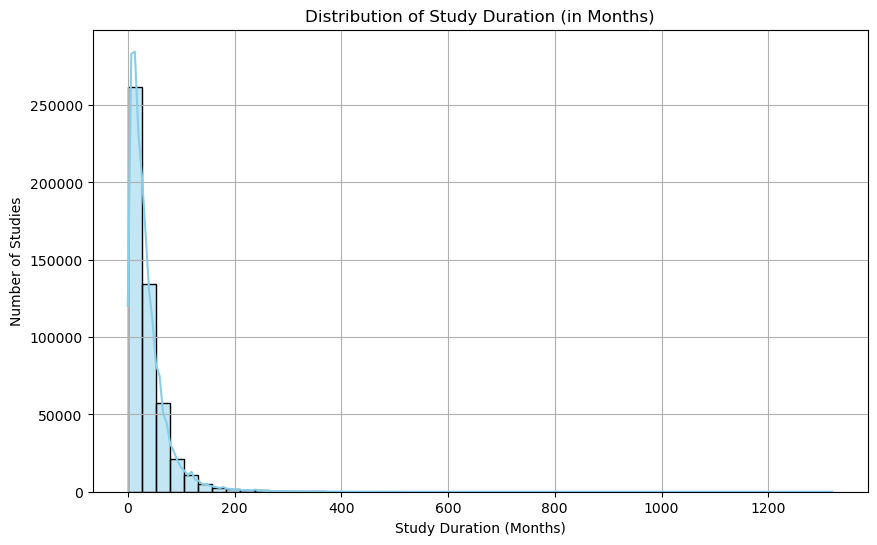

In [24]:
# Drop missing durations for visualization
durations = df['Study_Duration_From_Dates'].dropna()

plt.figure(figsize=(10, 6))
sns.histplot(durations, bins=50, kde=True, color='skyblue')
plt.title('Distribution of Study Duration (in Months)')
plt.xlabel('Study Duration (Months)')
plt.ylabel('Number of Studies')
plt.grid(True)
plt.show()


In [25]:
df['Study_Duration_From_Dates'].isnull().sum() 

5187

In [26]:
# Calculate the most common (mode) value
common_duration = df['Study_Duration_From_Dates'].mode().iloc[0]

# Replace missing values with the mode
df['Study_Duration_From_Dates'] = df['Study_Duration_From_Dates'].fillna(common_duration)
df['Study_Duration_From_Dates'].isnull().sum() 

0

## Handling outlaiers

### Enrollment 

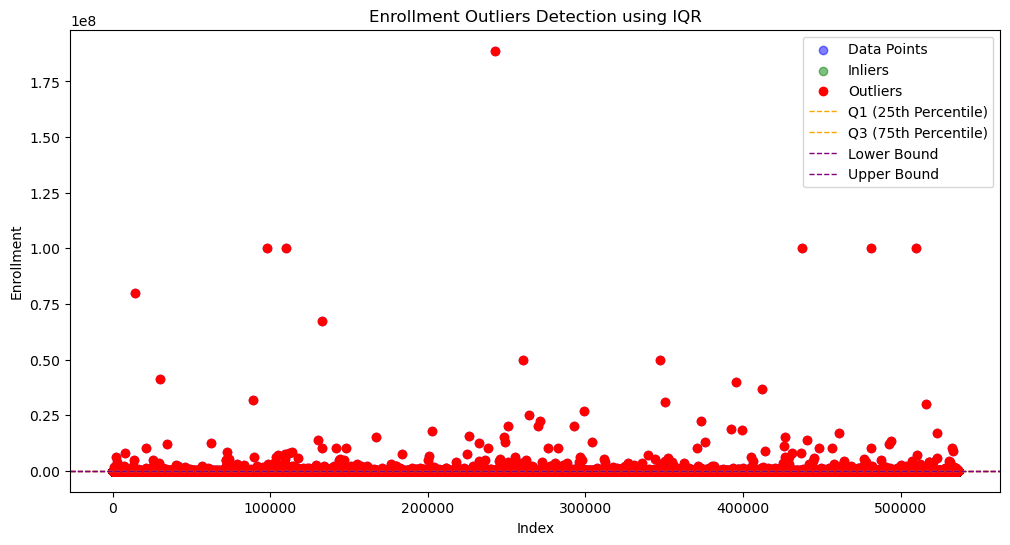

In [27]:
# IQR method for removing outliers

# Calculate IQR
Q1 = df['Enrollment'].quantile(0.25)
Q3 = df['Enrollment'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['Enrollment'] < lower_bound) | (df['Enrollment'] > upper_bound)]
inliers = df[(df['Enrollment'] >= lower_bound) & (df['Enrollment'] <= upper_bound)]

# Plot
plt.figure(figsize=(12, 6))

# Plot all data points
plt.scatter(df.index, df['Enrollment'], color='blue', alpha=0.5, label='Data Points')

# Highlight the inliers
plt.scatter(inliers.index, inliers['Enrollment'], color='green', alpha=0.5, label='Inliers')

# Highlight the outliers
plt.scatter(outliers.index, outliers['Enrollment'], color='red', label='Outliers')

# Plot IQR range
plt.axhline(Q1, color='orange', linestyle='dashed', linewidth=1, label='Q1 (25th Percentile)')
plt.axhline(Q3, color='orange', linestyle='dashed', linewidth=1, label='Q3 (75th Percentile)')

# Plot the lower and upper bounds
plt.axhline(lower_bound, color='purple', linestyle='dashed', linewidth=1, label='Lower Bound')
plt.axhline(upper_bound, color='purple', linestyle='dashed', linewidth=1, label='Upper Bound')

plt.title('Enrollment Outliers Detection using IQR')
plt.xlabel('Index')
plt.ylabel('Enrollment')
plt.legend()
plt.show()

In [28]:
print(df['Enrollment'].nlargest())

242907    188814085.0
97988      99999999.0
110136     99999999.0
437580     99999999.0
481274     99999999.0
Name: Enrollment, dtype: float64


In [29]:
Huge=df[df.Enrollment>100000]
pd.options.display.max_columns=31
Huge.head(5)

,NCT Number,Study Title,Study URL,Study Status,Brief Summary,Study Results,Conditions,Interventions,Primary Outcome Measures,Sponsor,Sex,Age,Phases,Enrollment,Funder Type,Study Type,Study Design,Other IDs,Start Date,Primary Completion Date,Completion Date,First Posted,Last Update Posted,Locations,Start_date_formated,Prim_completion_date_formated,Completion_date_formated,Primary_Completion_date_formated,Start_date_parsed,Completion_date_parsed,Study_Duration_From_Dates
801,NCT01600079,ZOSTAVAX™ (Zoster Vaccine Live) Long-term Effe...,https://clinicaltrials.gov/study/NCT01600079,COMPLETED,This study will describe the impact of vaccina...,NO,Herpes Zoster|Shingles,BIOLOGICAL: ZOSTAVAX™,Incidence of Herpes Zoster in Vaccinated and U...,Merck Sharp & Dohme LLC,ALL,"ADULT, OLDER_ADULT",NO_PHASE,1505647.0,INDUSTRY,OBSERVATIONAL,Observational Model: |Time Perspective: p,V211-024|8003.016,2012-05-15,2020-10-16,2020-10-16,2012-05-16,2022-07-14,Unknown,2012-05,yyyy-mm-dd,2020-10,2020-10,2012-05-01,2020-10-01,101.0
1791,NCT06641479,JiAngSu Maternal and INfant HEalth Database,https://clinicaltrials.gov/study/NCT06641479,ACTIVE_NOT_RECRUITING,With the implementation of China's universal t...,NO,Pregnant Women|Children,Observation,"Incidence of preterm birth, Regular contractio...",Yang Zhao,ALL,"CHILD, ADULT, OLDER_ADULT",NO_PHASE,1570360.0,OTHER,OBSERVATIONAL,Observational Model: |Time Perspective: p,NMU-2024-808,2020-01-01,2023-12-31,2029-12-31,2024-10-15,2024-10-15,"Nanjing Medical University, Nanjing, Jiangsu, ...",2020-01,yyyy-mm-dd,2029-12,2023-12,2020-01-01,2029-12-01,119.0
1862,NCT06372379,Development of a Multipurpose Dashboard to Mon...,https://clinicaltrials.gov/study/NCT06372379,NOT_YET_RECRUITING,An emergency department (ED) is a healthcare s...,NO,Emergency Medicine,OTHER: no intervention,"Daschboards, Develop three different control p...",Mario Negri Institute for Pharmacological Rese...,ALL,"ADULT, OLDER_ADULT",NO_PHASE,162000.0,OTHER,OBSERVATIONAL,Observational Model: |Time Perspective: p,8780_UC2,2025-02,2025-06,2027-02,2024-04-18,2024-11-22,Unknown,2025-02,yyyy-mm,2027-02,2025-06,2025-02-01,2027-02-01,24.0
2074,NCT01015079,The Association Between Cervical Cancer Screen...,https://clinicaltrials.gov/study/NCT01015079,UNKNOWN,To investigate the protective effect of cervic...,NO,Cervical Cancer|Cancer,Observation,Unknown,National Taiwan University Hospital,FEMALE,"CHILD, ADULT, OLDER_ADULT",NO_PHASE,6000000.0,OTHER,OBSERVATIONAL,Observational Model: |Time Perspective: p,200910043R,2009-11,NaN,NaN,2009-11-17,2009-11-17,"Taiwan Cervical Cancer Screening Task Force, T...",2009-11,missing,None,None,2009-11-01,NaT,12.0
2133,NCT02200679,National Study on Autism Spectrum Disorder in ...,https://clinicaltrials.gov/study/NCT02200679,COMPLETED,The aims of the national population-based stud...,NO,Autism Spectrum Disorders,Observation,"prevalence of autism spectrum disorder, The ou...",Fudan University,ALL,CHILD,NO_PHASE,143755.0,OTHER,OBSERVATIONAL,Observational Model: |Time Perspective: p,201302002,2014-01,2016-12,2016-12,2014-07-25,2017-05-16,"Capital Institute of Pediatrics, Beijing, Beij...",2014-01,yyyy-mm,2016-12,2016-12,2014-01-01,2016-12-01,35.0


In [30]:
#the mean value is 584, but the standard deviation is hugh (20,688). This happens due to those studies which has very large number of participants. To confromt this, we will categorize the data

bins = [0, 50, 200, 2000, 10000, float('inf')]
labels = ['Small', 'Medium', 'Large', 'Huge','Population_based']

df['Study_Size'] = pd.cut(df['Enrollment'], bins=bins, labels=labels, right=False)
df['Study_Size'].value_counts()


Study_Size
Medium              192168
Small               181104
Large               110404
Huge                 13028
Population_based      5954
Name: count, dtype: int64

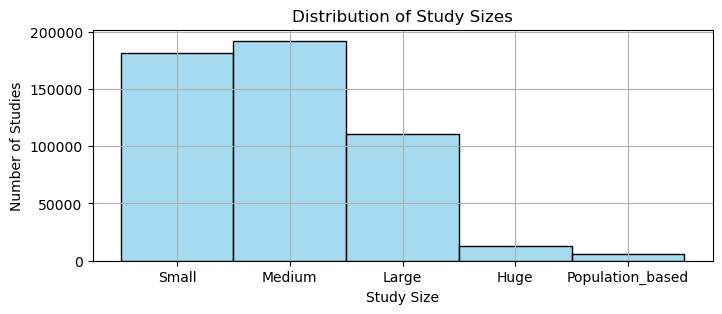

In [31]:
#Plot
plt.figure(figsize=(8, 3))
sns.histplot(df.Study_Size, bins=50, kde=False, color='skyblue')
plt.title('Distribution of Study Sizes')
plt.xlabel('Study Size')
plt.ylabel('Number of Studies')
plt.grid(True)
plt.show()

In [32]:
#On top of the categorization of Enrollment ("Study_Size") we will keep the numerical value after log transformation
#Definition of new column - Enrollment log
df['Enrollment_log'] = np.log1p(df['Enrollment'])
df['Enrollment_log'].describe()

count    502658.000000
mean          4.526577
std           1.504697
min           1.386294
25%           3.526361
50%           4.317488
75%           5.303305
max          19.056273
Name: Enrollment_log, dtype: float64

### Start and Completion Year

In [33]:
#Definition of new column - Start year
df['Start_Year'] = df['Start_date_formated'].str[:4].astype(float)
print(df.Start_Year.describe())

#Definition of new column - Completion year
df['Completion_Year'] = df['Completion_date_formated'].str[:4].astype(float)
print(df.Completion_Year.describe())

count    501669.000000
mean       2016.294421
std           6.321746
min        1916.000000
25%        2012.000000
50%        2018.000000
75%        2021.000000
max        2050.000000
Name: Start_Year, dtype: float64
count    498250.000000
mean       2019.225429
std           6.312003
min        1918.000000
25%        2015.000000
50%        2020.000000
75%        2024.000000
max        2100.000000
Name: Completion_Year, dtype: float64


In [34]:
#Remove studies that start in the future
df = df[df['Start_Year'] <= 2025]
print(df['Start_Year'].max())
print(df.shape)

2025.0
(501309, 35)


In [35]:
#Remove studies that complete in the future
df = df[df['Completion_Year'] <= 2025]
print(df['Completion_Year'].max())
print(df.shape)

2025.0
(436180, 35)


In [36]:
# Renaming column titles:
df.rename(columns={
    'NCT Number': 'NCT_Number',
    'Study Title':'Study_Title',
    'Study Status': 'Study_Status',
    'Study Results': 'Study_Results',
    'Brief Summary':'Brief_Summary',
    'Funder Type': 'Funder_Type',
    'Study Type':'Study_Type',
    'Study Title': 'Study_Title',
    'Study Design':'Study_Design',
    'Other IDs':  'Other_IDs',
    'Primary Outcome Measures':'Outcome_Measures',
    'Results First Posted':  'Results_First_Posted'
    
}, inplace=True)

df.columns


Index(['NCT_Number', 'Study_Title', 'Study URL', 'Study_Status',
       'Brief_Summary', 'Study_Results', 'Conditions', 'Interventions',
       'Outcome_Measures', 'Sponsor', 'Sex', 'Age', 'Phases', 'Enrollment',
       'Funder_Type', 'Study_Type', 'Study_Design', 'Other_IDs', 'Start Date',
       'Primary Completion Date', 'Completion Date', 'First Posted',
       'Last Update Posted', 'Locations', 'Start_date_formated',
       'Prim_completion_date_formated', 'Completion_date_formated',
       'Primary_Completion_date_formated', 'Start_date_parsed',
       'Completion_date_parsed', 'Study_Duration_From_Dates', 'Study_Size',
       'Enrollment_log', 'Start_Year', 'Completion_Year'],
      dtype='object')

### Duration

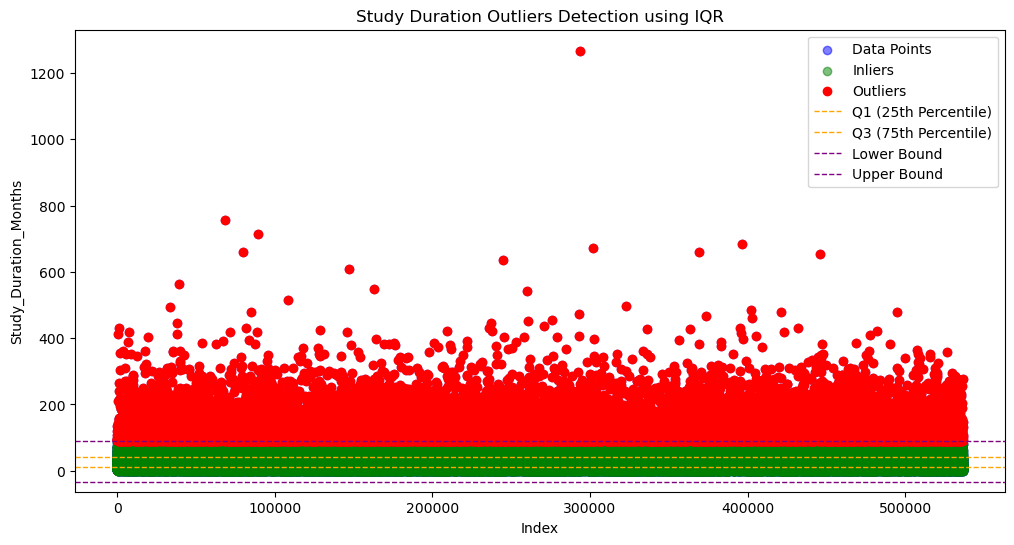

In [37]:
# Calculate IQR
Q1 = df['Study_Duration_From_Dates'].quantile(0.25)
Q3 = df['Study_Duration_From_Dates'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['Study_Duration_From_Dates'] < lower_bound) | (df['Study_Duration_From_Dates'] > upper_bound)]
inliers = df[(df['Study_Duration_From_Dates'] >= lower_bound) & (df['Study_Duration_From_Dates'] <= upper_bound)]

# Plot
plt.figure(figsize=(12, 6))

# Plot all data points
plt.scatter(df.index, df['Study_Duration_From_Dates'], color='blue', alpha=0.5, label='Data Points')

# Highlight the inliers
plt.scatter(inliers.index, inliers['Study_Duration_From_Dates'], color='green', alpha=0.5, label='Inliers')

# Highlight the outliers
plt.scatter(outliers.index, outliers['Study_Duration_From_Dates'], color='red', label='Outliers')

# Plot IQR range
plt.axhline(Q1, color='orange', linestyle='dashed', linewidth=1, label='Q1 (25th Percentile)')
plt.axhline(Q3, color='orange', linestyle='dashed', linewidth=1, label='Q3 (75th Percentile)')

# Plot the lower and upper bounds
plt.axhline(lower_bound, color='purple', linestyle='dashed', linewidth=1, label='Lower Bound')
plt.axhline(upper_bound, color='purple', linestyle='dashed', linewidth=1, label='Upper Bound')

plt.title('Study Duration Outliers Detection using IQR')
plt.xlabel('Index')
plt.ylabel('Study_Duration_Months')
plt.legend()
plt.show()

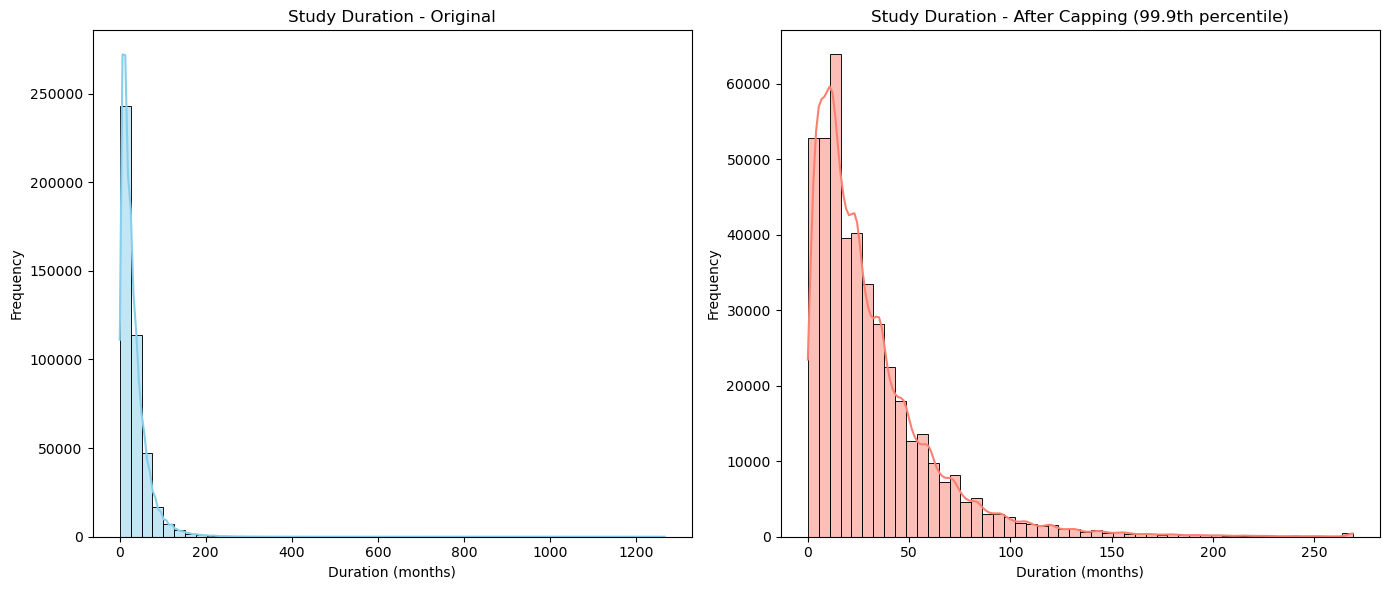

In [38]:
#capping to remove the upper outliers:
# Compute 99.9th percentile
upper = df['Study_Duration_From_Dates'].quantile(0.999)

# Cap the values at 95.5th percentile
durations_capped = df['Study_Duration_From_Dates'].clip(upper=upper)

# Original and capped duration
df['Study_Duration_Capped'] = df['Study_Duration_From_Dates'].clip(upper=upper)

plt.figure(figsize=(14, 6))

# Before capping
plt.subplot(1, 2, 1)
sns.histplot(df['Study_Duration_From_Dates'], bins=50, kde=True, color='skyblue')
plt.title('Study Duration - Original')
plt.xlabel('Duration (months)')
plt.ylabel('Frequency')

# After capping
plt.subplot(1, 2, 2)
sns.histplot(df['Study_Duration_Capped'], bins=50, kde=True, color='salmon')
plt.title('Study Duration - After Capping (99.9th percentile)')
plt.xlabel('Duration (months)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()




## Feature categorization

In [39]:
df.Age.value_counts()

Age
ADULT, OLDER_ADULT           280529
ADULT                         64419
CHILD, ADULT, OLDER_ADULT     39104
CHILD                         27515
CHILD, ADULT                  17810
OLDER_ADULT                    6803
Name: count, dtype: int64

In [40]:
#simplify the categories in the Age column:
def simplify_age(age_str):
    age_set = set(age_str.replace(" ", "").split(","))
    
    if age_set == {'CHILD', 'ADULT', 'OLDER_ADULT'}:
        return 'ALL'
    elif age_set == {'ADULT', 'OLDER_ADULT'} or age_set == {'CHILD', 'ADULT'}:
        return 'ADULT'
    elif len(age_set) == 1:
        return list(age_set)[0]
    else:
        return 'ALL'  # fallback for unexpected combos

df['Age_Simplified'] = df['Age'].apply(simplify_age)
print(df.Age_Simplified.value_counts())
print(df.Age_Simplified.info())

Age_Simplified
ADULT          362758
ALL             39104
CHILD           27515
OLDER_ADULT      6803
Name: count, dtype: int64
<class 'pandas.core.series.Series'>
Index: 436180 entries, 1 to 536388
Series name: Age_Simplified
Non-Null Count   Dtype 
--------------   ----- 
436180 non-null  object
dtypes: object(1)
memory usage: 6.7+ MB
None


In [41]:
df.Funder_Type.value_counts()

Funder_Type
OTHER        308858
INDUSTRY     100893
OTHER_GOV     11653
NIH            6932
FED            3773
NETWORK        3508
INDIV           492
UNKNOWN          68
AMBIG             3
Name: count, dtype: int64

In [42]:
# Define a mapping from the original categories to simplified ones
funder_map = {
     'INDUSTRY': 'Industry',
    'NIH': 'Government',
    'FED': 'Government',
    'OTHER_GOV': 'Government',
    'OTHER': 'Non-Governmental',
    'NETWORK': 'Non-Governmental',
    'INDIV': 'Non-Governmental',
    'UNKNOWN': 'Unknown',
    'AMBIG': 'Unknown'
}

# Create a new column with the simplified funder type
df['Funder_Simplified'] = df['Funder_Type'].map(funder_map)


In [43]:
print(df.Phases.value_counts())
print('Null Values:', df.Phases.isnull().sum())


Phases
NO_PHASE         271884
PHASE2            45824
PHASE1            36568
PHASE3            31677
PHASE4            28779
PHASE1|PHASE2     11491
PHASE2|PHASE3      5765
EARLY_PHASE1       4192
Name: count, dtype: int64
Null Values: 0


In [44]:
# Fill nulls first
df['Phases'] = df['Phases'].fillna('NO_PHASE')

# Create the simplified version
phase_map = {
    'EARLY_PHASE1': 'PHASE1',
    'PHASE1|PHASE2': 'PHASE2',
    'PHASE2|PHASE3': 'PHASE3',
    'NO_PHASE':'NO_PHASE'
}
df['Phases_Simplified'] = df['Phases'].replace(phase_map)



In [45]:
# categorization:
status_mapping = {
    'COMPLETED': 'Completed',
    'TERMINATED': 'Ended_Early',
    'WITHDRAWN': 'Ended_Early',
    'RECRUITING': 'Ongoing',
    'NOT_YET_RECRUITING': 'Ongoing',
    'ACTIVE_NOT_RECRUITING': 'Ongoing',
    'ENROLLING_BY_INVITATION': 'Ongoing',
    'SUSPENDED': 'Ended_Early',
    'UNKNOWN': 'Unknown'
}
df['Study_Status_Simplified'] = df['Study_Status'].map(status_mapping)


In [46]:
#Drop redundant columns: 
columns_to_drop = ['Age', 'Phases',  'Funder_Type', 'Other_IDs', 'Study_Duration_From_Dates','Last Update Posted','Start_date_parsed','Completion_date_parsed']
df.drop(columns=columns_to_drop, inplace=True)
df.shape
   

(436180, 32)

In [47]:
df.to_csv('ctgAll_EDA1205.csv', index=False)

## Adding features from AACT dataset
Merging with AACT joint table containing data from the following AACT tables: 'interventions','design_group_interventions', 'design_groups', 'dropouts',
'countries', 'retractions', 'outcome_analyses', 'outcome_analyses_groups', 'outcomes' and 'result_groups'

In [50]:
atcc=pd.read_csv('AACT_all data_unique.csv', usecols=['nct_id', 'intervention_type', 'allocation', 'MOA_mesh_term',
       'primary_mesh_term', 'safety', 'efficacy', 'Region', 'retraction',
       'study_success'],low_memory=False)
atcc.rename(columns={
    'nct_id': 'NCT_Number'
    }, inplace=True)


In [51]:
# Merge with main CTG dataset
dfm = df.merge(
    atcc,
    on='NCT_Number',
    how='left',
    validate='one_to_one'  
)


In [52]:
dfm.isnull().sum()

NCT_Number                               0
Study_Title                              0
Study URL                                0
Study_Status                             0
Brief_Summary                            0
Study_Results                            0
Conditions                               0
Interventions                            0
Outcome_Measures                         0
Sponsor                                  0
Sex                                      0
Enrollment                               0
Study_Type                               0
Study_Design                             0
Start Date                               0
Primary Completion Date              11557
Completion Date                          0
First Posted                             0
Locations                                0
Start_date_formated                      0
Prim_completion_date_formated            0
Completion_date_formated                 0
Primary_Completion_date_formated     11557
Study_Size 

In [53]:
# List of columns to replace NaN with 'Unknown'
columns_to_fill = [
    'intervention_type', 'allocation', 'MOA_mesh_term', 'primary_mesh_term',
    'Region','study_success'       
  ]
#Replace NaN values with 'Unknown' in the specified columns
for col in columns_to_fill:
    dfm[col] = dfm[col].fillna('Unknown')

#replace with zero:
columns_to_replace_with_zero=['safety', 'efficacy', 'retraction']
dfm[columns_to_replace_with_zero]=dfm[columns_to_replace_with_zero].fillna(0) 
dfm.isnull().sum()

NCT_Number                              0
Study_Title                             0
Study URL                               0
Study_Status                            0
Brief_Summary                           0
Study_Results                           0
Conditions                              0
Interventions                           0
Outcome_Measures                        0
Sponsor                                 0
Sex                                     0
Enrollment                              0
Study_Type                              0
Study_Design                            0
Start Date                              0
Primary Completion Date             11557
Completion Date                         0
First Posted                            0
Locations                               0
Start_date_formated                     0
Prim_completion_date_formated           0
Completion_date_formated                0
Primary_Completion_date_formated    11557
Study_Size                        

In [54]:
columns_to_drop = ['Study_Title', 'Study URL','Brief_Summary', 'Study_Results','Outcome_Measures','Locations']
dfm = dfm.drop(columns=columns_to_drop)


### Feture engineering 

In [55]:
dfm['Safety_Proportion'] = dfm['safety'] / dfm['Enrollment'].replace(0, np.nan)
dfm['Efficacy_Proportion'] = dfm['efficacy'] / dfm['Enrollment'].replace(0, np.nan)
dfm[['Safety_Proportion', 'Efficacy_Proportion']] = dfm[['Safety_Proportion', 'Efficacy_Proportion']].fillna(0)


### Categorization of AACT features

In [56]:
# Define a mapping from the original categories to simplified ones
int_map = {
     'DRUG': 'DRUG',
    'BIOLOGICAL ': 'BIOLOGICAL',
    'DEVICE': 'DEVICE AND IVD',
'COMBINATION_PRODUCT': 'DRUG',
    'PROCEDURE': 'DEVICE AND IVD',
'DIAGNOSTIC_TEST':'DEVICE AND IVD', 
 'RADIATION':'DEVICE AND IVD',
'DIETARY_SUPPLEMENT': 'DRUG',
'GENETIC':'OTHER',
'Unknown':'OTHER',
'OTHER': 'OTHER', 
'BEHAVIORAL': 'OTHER' 
}

# Create a new column with the simplified funder type
dfm['Intervention_type_Simplified'] = dfm['intervention_type'].map(int_map)
dfm['Intervention_type_Simplified'].value_counts()

Intervention_type_Simplified
DRUG              159183
OTHER             156384
DEVICE AND IVD    102017
Name: count, dtype: int64

In [57]:
columns_to_drop = ['intervention_type']
dfm = dfm.drop(columns=columns_to_drop)


In [58]:
dfm.allocation.value_counts()

allocation
RANDOMIZED          226416
Other_or_Unknown    132131
Unknown              42938
NON_RANDOMIZED       34695
Name: count, dtype: int64

In [59]:
# Define a mapping from the original categories to simplified ones
allo_map = {
     'RANDOMIZED':'RANDOMIZED',
'Other_or_Unknown':'OTHER',
'Other_or_Unknown':'OTHER',
'Other_or_Unknown':'OTHER'
}

# Create a new column with the simplified funder type
dfm['allocation_Simplified'] = dfm['allocation'].map(allo_map)
dfm['allocation_Simplified'].value_counts()

allocation_Simplified
RANDOMIZED    226416
OTHER         132131
Name: count, dtype: int64

In [60]:
columns_to_drop = ['allocation']
dfm = dfm.drop(columns=columns_to_drop)

In [61]:
dfm.Region.value_counts()

Region
North America                134289
Europe                       113741
Unknown                       73158
East Asia                     49602
Other                         20139
Africa                        16376
Latin America & Caribbean      8869
South Asia                     7250
Southeast Asia                 6073
Middle East                    3713
Oceania                        2970
Name: count, dtype: int64

In [62]:
# Define a mapping from the original categories to simplified ones
reg_map = {
     'North America':'North America',
'Europe':'Europe',
'East Asia':'East Asia',
'Unknown':'OTHER',
    'Africa':'OTHER',
    'Latin America & Caribbean':'OTHER',
    'Other':'OTHER',
    'Southeast Asia':'OTHER',
    'South Asia ':'OTHER',
    'Oceania': 'OTHER',
    'Middle East': 'OTHER',
}

# Create a new column with the simplified funder type
dfm['region_Simplified'] = dfm['Region'].map(reg_map)
dfm['region_Simplified'].value_counts()

region_Simplified
North America    134289
OTHER            131298
Europe           113741
East Asia         49602
Name: count, dtype: int64

In [63]:
columns_to_drop = ['Region']
dfm = dfm.drop(columns=columns_to_drop)

## Standardization

In [64]:
# Columns to standardize
columns_to_scale = ['Enrollment', 'Enrollment_log', 'Start_Year', 'Completion_Year',
                    'Study_Duration_Capped']

# Initialize the scaler
scaler_standard = StandardScaler()

# Fit, transform, and create a new DataFrame with matching index and renamed columns
dfm_standardized = pd.DataFrame(
    scaler_standard.fit_transform(df[columns_to_scale]),
    columns=[col + '_std' for col in columns_to_scale],
    index=df.index  # Ensures rows match exactly
)

# Concatenate standardized data back to the original DataFrame
dfm = pd.concat([dfm, dfm_standardized], axis=1)


### One-Hot Encoding


In [65]:
# Column selection
columns_to_encode = ['region_Simplified','Study_Status_Simplified', 'Sex', 'Age_Simplified', 'Phases_Simplified', 
                     'Funder_Simplified','Study_Size','Study_Type','Intervention_type_Simplified', 
                     'allocation_Simplified']
df_encoded = pd.get_dummies(dfm[columns_to_encode], prefix=columns_to_encode)

# Drop the original categorical columns from df
df_remaining = dfm.drop(columns=columns_to_encode)

# Concatenate original data (without encoded columns) with one-hot encoded columns
df_final = pd.concat([df_remaining, df_encoded], axis=1)
print(df_final.shape)
print(df_final.columns)

(517826, 68)
Index(['NCT_Number', 'Study_Status', 'Conditions', 'Interventions', 'Sponsor',
       'Enrollment', 'Study_Design', 'Start Date', 'Primary Completion Date',
       'Completion Date', 'First Posted', 'Start_date_formated',
       'Prim_completion_date_formated', 'Completion_date_formated',
       'Primary_Completion_date_formated', 'Enrollment_log', 'Start_Year',
       'Completion_Year', 'Study_Duration_Capped', 'MOA_mesh_term',
       'primary_mesh_term', 'safety', 'efficacy', 'retraction',
       'study_success', 'Safety_Proportion', 'Efficacy_Proportion',
       'Enrollment_std', 'Enrollment_log_std', 'Start_Year_std',
       'Completion_Year_std', 'Study_Duration_Capped_std',
       'region_Simplified_East Asia', 'region_Simplified_Europe',
       'region_Simplified_North America', 'region_Simplified_OTHER',
       'Study_Status_Simplified_Completed',
       'Study_Status_Simplified_Ended_Early',
       'Study_Status_Simplified_Ongoing', 'Study_Status_Simplified_Unknow

In [66]:
df.to_csv('ctgAll_EDA1205_atcc_std_3005_3.csv')